In [7]:
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from torchvision import transforms
from tqdm import tqdm
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [8]:
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 20
KD_TEMPERATURE = 4.0
KD_ALPHA = 0.5 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
dataset = get_dataset(dataset="waterbirds", download=True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.ToTensor()
])

train_data = dataset.get_subset("train", transform=transform)
val_data = dataset.get_subset("val", transform=transform)
test_data = dataset.get_subset("test", transform=transform)

train_loader = get_train_loader("standard", train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

metadata_array = test_data.metadata_array
bird_type_idx = dataset.metadata_fields.index('y')
background_idx = dataset.metadata_fields.index('background')

bird_type = metadata_array[:, bird_type_idx]
background = metadata_array[:, background_idx]

id_mask = ((bird_type == 0) & (background == 0)) | ((bird_type == 1) & (background == 1))
id_indices = torch.where(id_mask)[0]
id_data = torch.utils.data.Subset(test_data, id_indices)
id_loader = DataLoader(id_data, batch_size=BATCH_SIZE, shuffle=False)

ood_mask = ((bird_type == 0) & (background == 1)) | ((bird_type == 1) & (background == 0))
ood_indices = torch.where(ood_mask)[0]
ood_data = torch.utils.data.Subset(test_data, ood_indices)
ood_loader = DataLoader(ood_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
teacher_model = torch.hub.load('pytorch/vision:v0.13.0', 'resnet50', pretrained=False)
teacher_model.fc = nn.Linear(2048, 2)  
teacher_model = teacher_model.to(DEVICE)

student_model = torch.hub.load('pytorch/vision:v0.13.0', 'resnet18', pretrained=False)
student_model.fc = nn.Linear(512, 2)
student_model = student_model.to(DEVICE)

Using cache found in C:\Users\akhan/.cache\torch\hub\pytorch_vision_v0.13.0
c:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in C:\Users\akhan/.cache\torch\hub\pytorch_vision_v0.13.0


In [11]:
ce_criterion = nn.CrossEntropyLoss()

def kd_loss_fn(student_logits, teacher_logits, temperature=KD_TEMPERATURE):
    teacher_probs = torch.softmax(teacher_logits / temperature, dim=1)
    student_log_probs = torch.log_softmax(student_logits / temperature, dim=1)
    kl_div = torch.sum(teacher_probs * (torch.log(teacher_probs) - student_log_probs), dim=1).mean()
    return kl_div * (temperature**2)

In [12]:
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=LR)
best_teacher_val_acc = 0.0

teacher_start_time = time.time()
print("Training Teacher Model...")
for epoch in range(EPOCHS):
    teacher_model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y, _ = batch
        x, y = x.to(DEVICE), y.to(DEVICE)

        teacher_logits = teacher_model(x)
        loss = ce_criterion(teacher_logits, y)

        teacher_optimizer.zero_grad()
        loss.backward()
        teacher_optimizer.step()

        total_loss += loss.item() * x.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Teacher Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_train_loss:.4f}")

    teacher_model.eval()
    correct_val = 0
    with torch.no_grad():
        for x_val, y_val, _ in val_loader:
            x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)
            logits_val = teacher_model(x_val)
            preds_val = torch.argmax(logits_val, dim=1)
            correct_val += (preds_val == y_val).sum().item()
    val_acc = correct_val / len(val_loader.dataset)
    print(f"Teacher Validation Accuracy: {val_acc*100:.2f}%")

    if val_acc > best_teacher_val_acc:
        best_teacher_val_acc = val_acc
        os.makedirs('models', exist_ok=True)
        torch.save(teacher_model.state_dict(), 'models/teacher_resnet50_task3baseline.pt')

teacher_end_time = time.time()
teacher_training_time = teacher_end_time - teacher_start_time
print(f"Teacher Model Training Time: {teacher_training_time:.2f} seconds")

print("Teacher Model Training Complete.")

Training Teacher Model...


Epoch 1/20: 100%|██████████| 150/150 [01:43<00:00,  1.45it/s]


Teacher Epoch [1/20] - Loss: 0.4535
Teacher Validation Accuracy: 58.97%


Epoch 2/20: 100%|██████████| 150/150 [01:44<00:00,  1.43it/s]


Teacher Epoch [2/20] - Loss: 0.3184
Teacher Validation Accuracy: 56.88%


Epoch 3/20: 100%|██████████| 150/150 [01:44<00:00,  1.44it/s]


Teacher Epoch [3/20] - Loss: 0.3194
Teacher Validation Accuracy: 44.45%


Epoch 4/20: 100%|██████████| 150/150 [01:38<00:00,  1.52it/s]


Teacher Epoch [4/20] - Loss: 0.3069
Teacher Validation Accuracy: 53.71%


Epoch 5/20: 100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Teacher Epoch [5/20] - Loss: 0.2808
Teacher Validation Accuracy: 57.96%


Epoch 6/20: 100%|██████████| 150/150 [01:37<00:00,  1.55it/s]


Teacher Epoch [6/20] - Loss: 0.2870
Teacher Validation Accuracy: 59.22%


Epoch 7/20: 100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Teacher Epoch [7/20] - Loss: 0.2848
Teacher Validation Accuracy: 57.30%


Epoch 8/20: 100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Teacher Epoch [8/20] - Loss: 0.2812
Teacher Validation Accuracy: 53.38%


Epoch 9/20: 100%|██████████| 150/150 [01:44<00:00,  1.44it/s]


Teacher Epoch [9/20] - Loss: 0.2700
Teacher Validation Accuracy: 60.47%


Epoch 10/20: 100%|██████████| 150/150 [01:43<00:00,  1.45it/s]


Teacher Epoch [10/20] - Loss: 0.2744
Teacher Validation Accuracy: 59.13%


Epoch 11/20: 100%|██████████| 150/150 [01:43<00:00,  1.45it/s]


Teacher Epoch [11/20] - Loss: 0.2661
Teacher Validation Accuracy: 54.21%


Epoch 12/20: 100%|██████████| 150/150 [01:43<00:00,  1.45it/s]


Teacher Epoch [12/20] - Loss: 0.2660
Teacher Validation Accuracy: 51.54%


Epoch 13/20: 100%|██████████| 150/150 [01:44<00:00,  1.43it/s]


Teacher Epoch [13/20] - Loss: 0.2612
Teacher Validation Accuracy: 59.88%


Epoch 14/20: 100%|██████████| 150/150 [01:45<00:00,  1.43it/s]


Teacher Epoch [14/20] - Loss: 0.2556
Teacher Validation Accuracy: 58.30%


Epoch 15/20: 100%|██████████| 150/150 [01:41<00:00,  1.47it/s]


Teacher Epoch [15/20] - Loss: 0.2429
Teacher Validation Accuracy: 64.22%


Epoch 16/20: 100%|██████████| 150/150 [01:42<00:00,  1.46it/s]


Teacher Epoch [16/20] - Loss: 0.2364
Teacher Validation Accuracy: 61.47%


Epoch 17/20: 100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Teacher Epoch [17/20] - Loss: 0.2388
Teacher Validation Accuracy: 58.55%


Epoch 18/20: 100%|██████████| 150/150 [01:43<00:00,  1.45it/s]


Teacher Epoch [18/20] - Loss: 0.2341
Teacher Validation Accuracy: 52.46%


Epoch 19/20: 100%|██████████| 150/150 [01:43<00:00,  1.44it/s]


Teacher Epoch [19/20] - Loss: 0.2262
Teacher Validation Accuracy: 72.73%


Epoch 20/20: 100%|██████████| 150/150 [01:43<00:00,  1.45it/s]


Teacher Epoch [20/20] - Loss: 0.2187
Teacher Validation Accuracy: 65.89%
Teacher Model Training Time: 2380.81 seconds
Teacher Model Training Complete.


In [13]:
student_optimizer = optim.Adam(student_model.parameters(), lr=LR)
best_student_val_acc = 0.0

student_start_time = time.time()
print("Training Student Model with Knowledge Distillation...")
for epoch in range(EPOCHS):
    student_model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y, _ = batch
        x, y = x.to(DEVICE), y.to(DEVICE)

        with torch.no_grad():
            teacher_logits = teacher_model(x)

        student_logits = student_model(x)
        
        loss_ce = ce_criterion(student_logits, y)
        loss_kd = kd_loss_fn(student_logits, teacher_logits, temperature=KD_TEMPERATURE)
        loss = KD_ALPHA * loss_kd + (1 - KD_ALPHA) * loss_ce

        student_optimizer.zero_grad()
        loss.backward()
        student_optimizer.step()

        total_loss += loss.item() * x.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Student Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_train_loss:.4f}")

    student_model.eval()
    correct_val = 0
    with torch.no_grad():
        for x_val, y_val, _ in val_loader:
            x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)
            logits_val = student_model(x_val)
            preds_val = torch.argmax(logits_val, dim=1)
            correct_val += (preds_val == y_val).sum().item()
    val_acc = correct_val / len(val_loader.dataset)
    print(f"Student Validation Accuracy: {val_acc*100:.2f}%")
    
    if val_acc > best_student_val_acc:
        best_student_val_acc = val_acc
        os.makedirs('models', exist_ok=True)
        torch.save(student_model.state_dict(), 'models/student_resnet18_task3baseline.pt')

student_end_time = time.time()
student_training_time = student_end_time - student_start_time
print(f"Student Model Training Time: {student_training_time:.2f} seconds")

print("Student Model Training Complete.")

Training Student Model with Knowledge Distillation...


Epoch 1/20: 100%|██████████| 150/150 [01:27<00:00,  1.72it/s]


Student Epoch [1/20] - Loss: 0.5166
Student Validation Accuracy: 57.38%


Epoch 2/20: 100%|██████████| 150/150 [01:25<00:00,  1.76it/s]


Student Epoch [2/20] - Loss: 0.4159
Student Validation Accuracy: 70.73%


Epoch 3/20: 100%|██████████| 150/150 [01:25<00:00,  1.75it/s]


Student Epoch [3/20] - Loss: 0.3964
Student Validation Accuracy: 65.97%


Epoch 4/20: 100%|██████████| 150/150 [01:25<00:00,  1.76it/s]


Student Epoch [4/20] - Loss: 0.3612
Student Validation Accuracy: 63.89%


Epoch 5/20: 100%|██████████| 150/150 [01:24<00:00,  1.77it/s]


Student Epoch [5/20] - Loss: 0.3472
Student Validation Accuracy: 54.46%


Epoch 6/20: 100%|██████████| 150/150 [01:26<00:00,  1.74it/s]


Student Epoch [6/20] - Loss: 0.3324
Student Validation Accuracy: 59.88%


Epoch 7/20: 100%|██████████| 150/150 [01:19<00:00,  1.88it/s]


Student Epoch [7/20] - Loss: 0.3050
Student Validation Accuracy: 65.05%


Epoch 8/20: 100%|██████████| 150/150 [01:21<00:00,  1.84it/s]


Student Epoch [8/20] - Loss: 0.2797
Student Validation Accuracy: 62.47%


Epoch 9/20: 100%|██████████| 150/150 [01:20<00:00,  1.87it/s]


Student Epoch [9/20] - Loss: 0.2628
Student Validation Accuracy: 59.30%


Epoch 10/20: 100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


Student Epoch [10/20] - Loss: 0.2519
Student Validation Accuracy: 66.64%


Epoch 11/20: 100%|██████████| 150/150 [01:16<00:00,  1.95it/s]


Student Epoch [11/20] - Loss: 0.2375
Student Validation Accuracy: 60.63%


Epoch 12/20: 100%|██████████| 150/150 [01:17<00:00,  1.95it/s]


Student Epoch [12/20] - Loss: 0.2354
Student Validation Accuracy: 70.14%


Epoch 13/20: 100%|██████████| 150/150 [01:20<00:00,  1.86it/s]


Student Epoch [13/20] - Loss: 0.2136
Student Validation Accuracy: 67.64%


Epoch 14/20: 100%|██████████| 150/150 [01:17<00:00,  1.93it/s]


Student Epoch [14/20] - Loss: 0.2040
Student Validation Accuracy: 75.90%


Epoch 15/20: 100%|██████████| 150/150 [01:23<00:00,  1.80it/s]


Student Epoch [15/20] - Loss: 0.2009
Student Validation Accuracy: 59.63%


Epoch 16/20: 100%|██████████| 150/150 [01:21<00:00,  1.85it/s]


Student Epoch [16/20] - Loss: 0.1822
Student Validation Accuracy: 61.80%


Epoch 17/20: 100%|██████████| 150/150 [01:25<00:00,  1.75it/s]


Student Epoch [17/20] - Loss: 0.1727
Student Validation Accuracy: 59.88%


Epoch 18/20: 100%|██████████| 150/150 [01:24<00:00,  1.79it/s]


Student Epoch [18/20] - Loss: 0.1670
Student Validation Accuracy: 58.80%


Epoch 19/20: 100%|██████████| 150/150 [01:22<00:00,  1.82it/s]


Student Epoch [19/20] - Loss: 0.1626
Student Validation Accuracy: 64.55%


Epoch 20/20: 100%|██████████| 150/150 [01:22<00:00,  1.81it/s]


Student Epoch [20/20] - Loss: 0.1560
Student Validation Accuracy: 63.47%
Student Model Training Time: 1955.72 seconds
Student Model Training Complete.


In [14]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for x_eval, y_eval, _ in loader:
            x_eval, y_eval = x_eval.to(DEVICE), y_eval.to(DEVICE)
            logits_eval = model(x_eval)
            probs_eval = torch.softmax(logits_eval, dim=1)
            preds_eval = torch.argmax(logits_eval, dim=1)
            correct += (preds_eval == y_eval).sum().item()

            all_preds.append(preds_eval.cpu())
            all_labels.append(y_eval.cpu())
            all_probs.append(probs_eval.cpu())

    accuracy = correct / len(loader.dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_probs = torch.cat(all_probs)
    return accuracy, all_preds, all_labels, all_probs

id_acc, id_preds, id_labels, id_probs = evaluate(student_model, id_loader)
ood_acc, ood_preds, ood_labels, ood_probs = evaluate(student_model, ood_loader)

print(f"ID Accuracy (Majority Groups): {id_acc*100:.2f}%")
print(f"OOD Accuracy (Minority Groups): {ood_acc*100:.2f}%")

ID Accuracy (Majority Groups): 91.58%
OOD Accuracy (Minority Groups): 33.34%


In [15]:
def compute_B_MI(id_acc, ood_acc):
    if id_acc == 0:
        return 0.0
    return 1 - abs(id_acc - ood_acc) / id_acc

def compute_CSS(id_labels, id_preds, ood_labels, ood_preds, num_classes=2):
    def confusion_matrix(preds, labels, num_classes):
        cm = torch.zeros(num_classes, num_classes)
        for p, t in zip(preds, labels):
            cm[t, p] += 1
        return cm

    id_cm = confusion_matrix(id_preds, id_labels, num_classes)
    ood_cm = confusion_matrix(ood_preds, ood_labels, num_classes)

    sensitivities_id = []
    sensitivities_ood = []
    for c in range(num_classes):
        TP_id = id_cm[c, c]
        FN_id = id_cm[c, :].sum() - TP_id
        sens_id = TP_id / (TP_id + FN_id) if (TP_id + FN_id) > 0 else 0.0
        sensitivities_id.append(sens_id.item())

        TP_ood = ood_cm[c, c]
        FN_ood = ood_cm[c, :].sum() - TP_ood
        sens_ood = TP_ood / (TP_ood + FN_ood) if (TP_ood + FN_ood) > 0 else 0.0
        sensitivities_ood.append(sens_ood.item())

    diffs = [abs(sid - sood) for sid, sood in zip(sensitivities_id, sensitivities_ood)]
    css = 1 - (sum(diffs) / len(diffs))
    return css

def compute_FIS(id_labels, id_probs, ood_labels, ood_probs):
    correct_class_probs_id = [prob[lbl].item() for lbl, prob in zip(id_labels, id_probs)]
    mean_id_prob = np.mean(correct_class_probs_id)

    correct_class_probs_ood = [prob[lbl].item() for lbl, prob in zip(ood_labels, ood_probs)]
    mean_ood_prob = np.mean(correct_class_probs_ood) if len(correct_class_probs_ood) > 0 else 0.0

    if mean_id_prob == 0:
        fis = 0.0
    else:
        fis = mean_ood_prob / mean_id_prob
    return fis

B_MI_value = compute_B_MI(id_acc, ood_acc)
CSS_value = compute_CSS(id_labels, id_preds, ood_labels, ood_preds, num_classes=2)
FIS_value = compute_FIS(id_labels, id_probs, ood_labels, ood_probs)

print(f"B_MI: {B_MI_value:.4f}, CSS: {CSS_value:.4f}, FIS: {FIS_value:.4f}")

B_MI: 0.3641, CSS: 0.3897, FIS: 0.4552


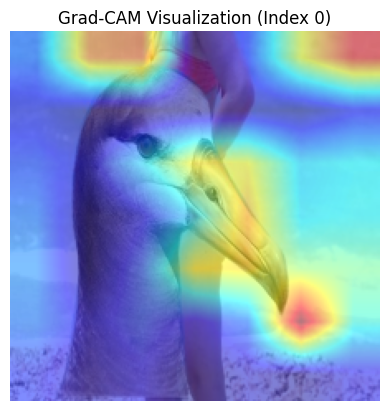

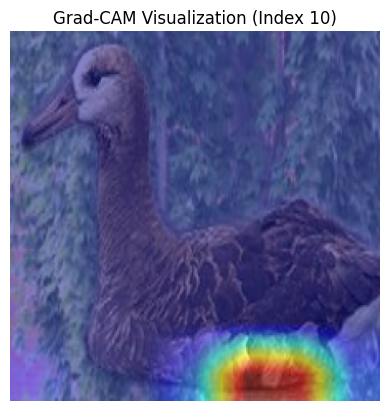

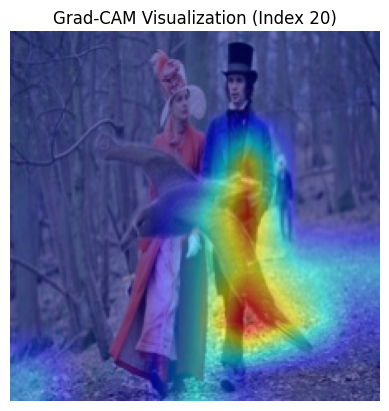

In [16]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

student_model.eval()
target_layer = student_model.layer4[-1]
cam = GradCAM(model=student_model, target_layers=[target_layer])

indices_for_vis = [0, 10, 20] 
for idx in indices_for_vis:
    img, label, meta = test_data[idx]
    input_tensor = img.unsqueeze(0).to(DEVICE)
    targets = [ClassifierOutputTarget(label)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    rgb_img = img.permute(1, 2, 0).numpy()
    rgb_img = np.float32(rgb_img) / np.max(rgb_img)
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure()
    plt.title(f"Grad-CAM Visualization (Index {idx})")
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()

In [18]:
teacher_model_size = sum(p.numel() for p in teacher_model.parameters()) * 4 / (1024**2)  
student_model_size = sum(p.numel() for p in student_model.parameters()) * 4 / (1024**2) 
print(f"Teacher Model Size: {teacher_model_size:.2f} MB")
print(f"Student Model Size: {student_model_size:.2f} MB")

print(f"Teacher Training Time: {teacher_training_time:.2f} seconds")
print(f"Student Training Time: {student_training_time:.2f} seconds")
print("Forward/Backward passes per epoch (Teacher):", len(train_loader))
print("Forward/Backward passes per epoch (Student):", len(train_loader))


Teacher Model Size: 89.69 MB
Student Model Size: 42.64 MB
Teacher Training Time: 2380.81 seconds
Student Training Time: 1955.72 seconds
Forward/Backward passes per epoch (Teacher): 150
Forward/Backward passes per epoch (Student): 150
